In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn.manifold import TSNE

from vislogprob import *

sns.set()

### Leitura dos Dados:

In [29]:
dados = pd.read_excel('C:/Users/Pedro/Documents/Ufrj/Exploração Mineral/PMAsBi/Para de Minas2.xls')
dados_bi = dados['Bi (PPM)']
dados_as = dados['As (PPM)']

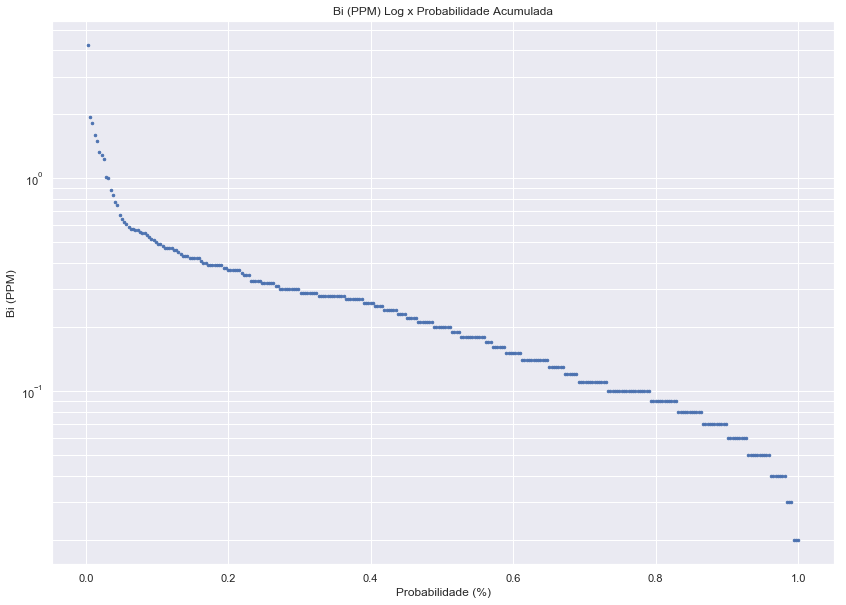

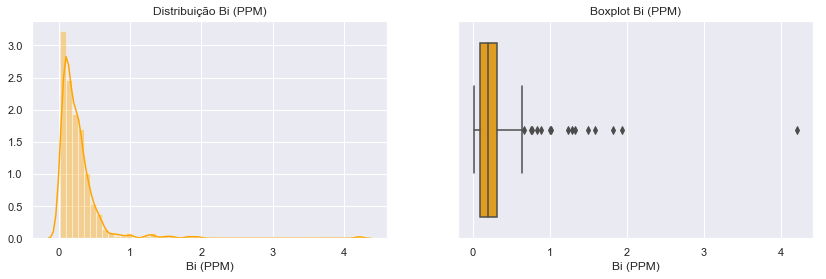

In [33]:
x2, y2 = vis_logprob(dados_bi)

* Gerando Tabela de Frequências:

In [31]:
freq = tabela_frequencias(dados_as)

count    315.000000
mean       8.810476
std       18.542712
min        0.100000
25%        0.700000
50%        1.700000
75%       10.350000
max      178.500000
Name: As (PPM), dtype: float64


In [32]:
freq

,Mínimo,Máximo,Mínimo (log),Frequência Absoluta,Frequência Relativa (%),Frequência Acumulada,Frequência Acumulada Direta (%),Frequência Acumulada Invertida (%)
0,0.100000,19.298118,-1.000000,266.0,84.444444,266.0,0.844444,1.000000
1,19.398118,38.596236,1.287760,36.0,11.428571,302.0,0.958730,0.993651
2,38.696236,57.894354,1.587669,6.0,1.904762,308.0,0.977778,0.993651
3,57.994354,77.192471,1.763386,3.0,0.952381,311.0,0.987302,0.993651
4,77.292471,96.490589,1.888137,2.0,0.634921,313.0,0.993651,0.993651
8,154.484943,178.500000,2.188886,2.0,0.634921,315.0,1.000000,0.844444


### Calculando a Inércia do Modelo:

Text(0.5, 0, 'Nº Clusters')

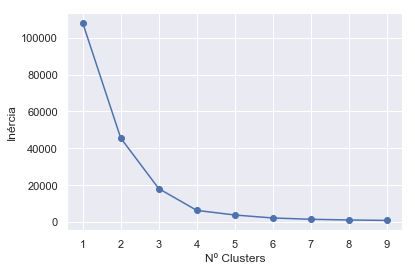

In [36]:
xy = pd.DataFrame()
xy.insert(loc=0, column='Teor As', value=x)
xy.insert(loc=1, column='Prob As', value=y[::-1])
xy.insert(loc=2, column='Teor Bi', value=x2)
xy.insert(loc=3, column='Prob Bi', value=y2[::-1])

X = xy.values
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k , random_state=3425)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.ylabel('Inércia')
plt.xlabel('Nº Clusters')

### Calculando Silhuetas:

O "score" da silhueta nos da o valor da média para todas as amostras. Isto nos da uma perspectiva sobre a densidade e a separação entre as amostras de cada cluster.

In [37]:
range_n_clusters = [2,3,4,5,6,7,8,9]
silhouette_score_max = 0
clusters = 0

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=3425)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > silhouette_score_max:
        silhouette_score_max = silhouette_avg
        clusters = n_clusters
    print("Para n_clusters =", n_clusters, ", a média do silhouette_score é :", silhouette_avg)

Para n_clusters = 2 , a média do silhouette_score é : 0.8660778894548129
Para n_clusters = 3 , a média do silhouette_score é : 0.7675139326604636
Para n_clusters = 4 , a média do silhouette_score é : 0.7774809640271688
Para n_clusters = 5 , a média do silhouette_score é : 0.7503532839150285
Para n_clusters = 6 , a média do silhouette_score é : 0.7495725628028006
Para n_clusters = 7 , a média do silhouette_score é : 0.7508454513901248
Para n_clusters = 8 , a média do silhouette_score é : 0.7405254453337
Para n_clusters = 9 , a média do silhouette_score é : 0.6614685001954225


### Visualizando o Modelo:

In [43]:
modelo = KMeans(n_clusters=2, random_state=3425)
modelo.fit(X)
labels = modelo.predict(X)

In [44]:
df_clustered = pd.DataFrame()
df_clustered.insert(0, 'Prob', xy['Prob As'])
df_clustered.insert(1, 'Teor', xy['Teor As'])
df_clustered.insert(2, 'Class', labels)

In [45]:
means = []

for classe in df_clustered.Class.unique():
    mean = np.mean(df_clustered.Teor[df_clustered.Class == classe])
    means.append(mean)
    
classes_zip = zip(df_clustered.Class.unique(), means)
classes_zip = list(classes_zip)
classes_zip = sorted(classes_zip, key = lambda x: x[1], reverse=True)

anomalo = classes_zip[0][0]

ordem = 1

for n in classes_zip:
    if n[0] == anomalo:
        df_clustered.Class = df_clustered.Class.apply(lambda row: 'Anômalo' 
                         if row == anomalo 
                         else row)
    else:
        df_clustered.Class = df_clustered.Class.apply(lambda row: 'Amostras Background ('+str(ordem)+'º cluster)' 
                         if row == n[0] 
                         else row)
        ordem = ordem+1

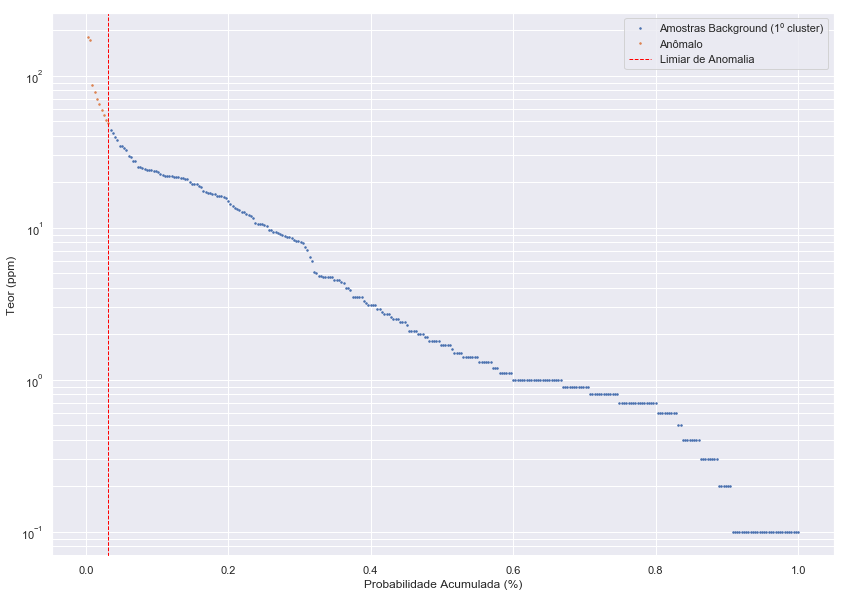

In [46]:
fig = plt.figure(figsize=(14,10))
plt.grid(True, which='both')

for n in df_clustered.Class.unique():
    plt.semilogy(df_clustered.Prob[df_clustered.Class == n],
                     df_clustered.Teor[df_clustered.Class == n],'o',
                      label=n, markersize=1.5)
    if n == 'Anômalo':
        limiar = np.max(df_clustered.Prob[df_clustered.Teor == np.min(df_clustered.Teor[df_clustered.Class == 'Anômalo'])])
        plt.axvline(float(limiar), linestyle='--', label='Limiar de Anomalia', linewidth=1.0, c='red')
    
plt.xlabel('Probabilidade Acumulada (%)')
plt.ylabel('Teor (ppm)')
plt.legend()

### Plotando Resultados no Mapa:

In [47]:
import geopandas as gpd
import pyproj
from shapely import geometry

In [51]:
pyproj.Proj.srs()

RuntimeError: b'projection not named'

In [52]:
p1 = pyproj.Proj(proj='utm', zone=23, datum='WGS84')
p2 = 

* Convertendo Sistema de Coordenadas:

In [56]:
p1 = pyproj.Proj(proj='utm', zone=23, datum='WGS84')
p2 = pyproj.Proj(proj='latlong', datum='WGS84')

df_clustered['Y'], df_clustered['X'] = pyproj.transform(p1, p2,
                                                        dados['Long (X)'].values,
                                                        dados['Lat (Y)'].values)

In [57]:
df_clustered

,Prob,Teor,Class,Y,X
0,1.000000,0.1,Amostras Background (1º cluster),-0.000071,-49.489207
1,0.996825,0.1,Amostras Background (1º cluster),-0.000071,-49.489206
2,0.993651,0.1,Amostras Background (1º cluster),-0.000071,-49.489206
3,0.990476,0.1,Amostras Background (1º cluster),-0.000071,-49.489200
4,0.987302,0.1,Amostras Background (1º cluster),-0.000071,-49.489199
5,0.984127,0.1,Amostras Background (1º cluster),-0.000070,-49.489213
6,0.980952,0.1,Amostras Background (1º cluster),-0.000070,-49.489204
7,0.977778,0.1,Amostras Background (1º cluster),-0.000071,-49.489198
8,0.974603,0.1,Amostras Background (1º cluster),-0.000071,-49.489198
9,0.971429,0.1,Amostras Background (1º cluster),-0.000071,-49.489192


In [14]:
df_clustered['Geometria'] = [geometry.Point(x, y) for x, y in zip(df_clustered['X'], df_clustered['Y'])]

* Criação de um GeoDataFrame:

In [15]:
geo_df = gpd.GeoDataFrame(df_clustered, geometry='Geometria')

* Leitura de Shapefiles:

In [16]:
litologias = gpd.read_file('/home/optimatech-02/Nextcloud/Estagio/Notebooks/Estudos/PMAsBi/Litologia/pminas_lito.shp')
hidrog = gpd.read_file('/home/optimatech-02/Nextcloud/Estagio/Notebooks/Estudos/PMAsBi/Hidrografia/pminas_unifilar.shp')
estrut = gpd.read_file('/home/optimatech-02/Nextcloud/Estagio/Notebooks/Estudos/PMAsBi/Estrutura/pminas_estrut.shp')

* Criando Polygono de Interesse:

In [17]:
multipoints = geometry.MultiPoint(geo_df.Geometria[geo_df.Class == 'Anômalo'].reset_index().Geometria)
bounds = multipoints.envelope

areainteresse = pd.DataFrame()
areainteresse.insert(0, 'Geometria', [geometry.LineString(bounds.boundary)])
areainteresse = gpd.GeoDataFrame(areainteresse, geometry='Geometria')

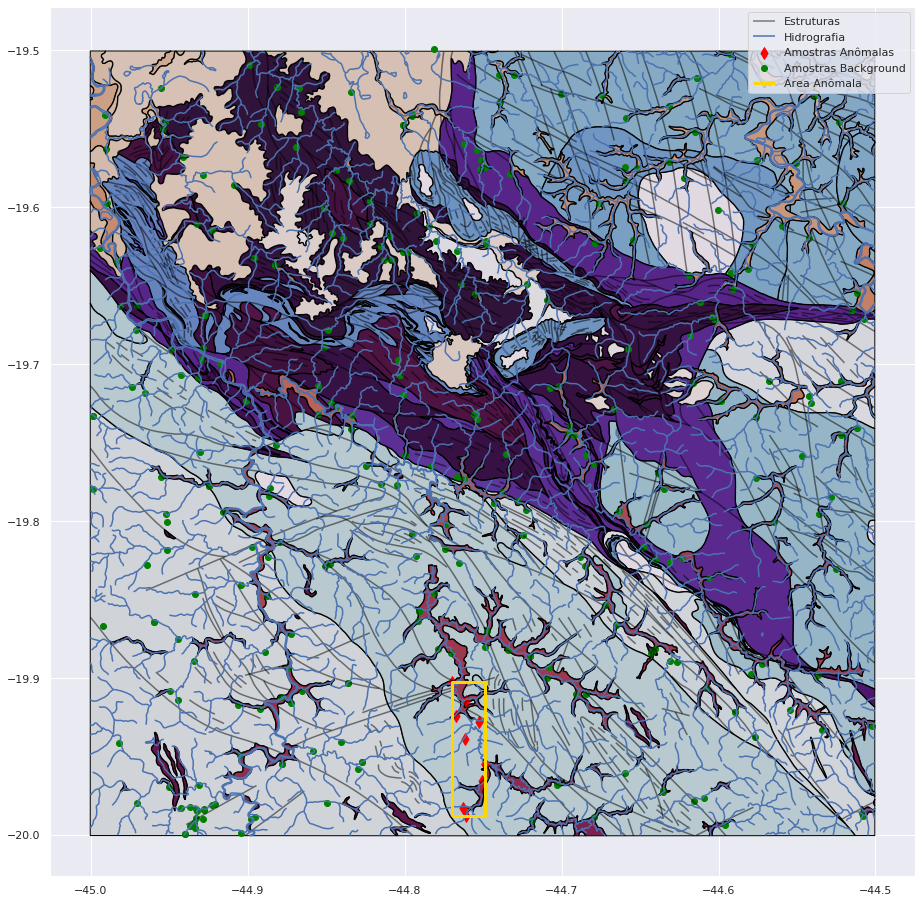

In [18]:
fig, ax = plt.subplots(figsize = (20,16)) 

litologias.plot(facecolor='w', edgecolor='black', ax=ax, cmap='twilight')
estrut.plot(ax=ax, color='black', alpha=0.5, label='Estruturas')
hidrog.plot(ax=ax, label='Hidrografia')
geo_df[geo_df.Class == 'Anômalo'].plot(ax=ax, color='red', markersize = 70, marker='d', label='Amostras Anômalas')
geo_df[geo_df.Class != 'Anômalo'].plot(ax=ax, color='green', label='Amostras Background')
areainteresse.plot(ax=ax, color='gold', linewidth=3, label='Área Anômala')
plt.legend()

## Clustering com K-Prototypes:

In [19]:
from kmodes.kprototypes import KPrototypes

In [20]:
df_join = pd.read_csv('biasjoined.csv', usecols=['Prob', 'Teor', 'Class', 'NOME_UNIDA', 'Geometria'])

In [21]:
X = np.array(df_join[['Teor', 'Prob', 'NOME_UNIDA']])

In [22]:
#ncost = []
#ks = range(1,7)
#
#for n in range(1,7):
#    modelo = KPrototypes(n_clusters=n, init='Huang', n_init=1, verbose=2)
#    clusters = modelo.fit_predict(X, categorical=[2])
#    ncost.append(modelo.cost_)
#
#plt.plot(ks, ncost, '-o')
#plt.xlabel('N° de Clusters')
#plt.ylabel('n_cost')

In [23]:
#nclusters = int(input())
#modelo = KPrototypes(n_clusters=nclusters, init='Cao', n_init=1, verbose=2)
#clusters = modelo.fit_predict(X, categorical=[2])
#ncost.append(modelo.cost_)

In [24]:
#fig = plt.figure(figsize=(12,8))
#plt.grid(True, which="both")
#
#for i in set(modelo.labels_):
#    index = modelo.labels_ == i
#    plt.semilogy(X[index, 1], X[index, 0], 'o')
#    plt.suptitle('Data points categorized with category score', fontsize=18)
#    plt.xlabel('Category Score', fontsize=16)
#    plt.ylabel('Category Type', fontsize=16)
#plt.show()

In [25]:
#df_join.insert(5,'Kprototypes', modelo.labels_)

In [26]:
#df_join.NOME_UNIDA[df_join.Kprototypes == 0].unique()

In [27]:
#df_join[['Prob', 'Teor']].values